# Mini-project 6.3 Customer segmentation with clustering

#Initial data exploration and assessment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from scipy.cluster.hierarchy import dendrogram, linkage

data = pd.read_csv('https://github.com/FourthRevGitHub/CAM_DS_Public-Data-Sets/raw/main/Course%201/Week%206/CUSTOMERS_CLEAN.zip')

In [ ]:
data.head()

Quantity         City      Continent Postal_Code     State_Province  \
0         3     Leinster        Oceania        6437  Western Australia   
1         2      Berowra        Oceania        2081    New South Wales   
2         2      Berowra        Oceania        2081    New South Wales   
3         1  Northbridge        Oceania        2063    New South Wales   
4         1     Montréal  North America         NaN             Quebec   

  Order_Date Delivery_Date Total Revenue Unit Cost Discount OrderTypeLabel  \
0  01JAN2012     07JAN2012       $28.50     $9.10         .  Internet Sale   
1  01JAN2012     04JAN2012      $113.40    $56.90         .  Internet Sale   
2  01JAN2012     04JAN2012       $41.00    $18.50         .  Internet Sale   
3  01JAN2012     03JAN2012       $35.20    $29.60         .  Internet Sale   
4  01JAN2012     04JAN2012       $24.70    $23.60         .  Internet Sale   

  CustomerCountryLabel Customer_BirthDate              Customer_Group  \
0            Australia          08MAY1978  Internet/Catalog Customers   
1            Australia          13DEC1978     Orion Club Gold members   
2            Australia          13DEC1978     Orion Club Gold members   
3            Australia          22JUN1997     Orion Club Gold members   
4               Canada          28JAN1978     Orion Club Gold members   

                             Customer_Type    Order ID   Profit  \
0               Internet/Catalog Customers  1230000033   $1.20    
1    Orion Club Gold members high activity  1230000204  ($0.40)   
2    Orion Club Gold members high activity  1230000204   $4.00    
3    Orion Club Gold members high activity  1230000268   $5.60    
4  Orion Club Gold members medium activity  1230000487   $1.10    

   Days to Delivery  Loyalty Num  Customer ID  
0                 6           99         8818  
1                 3           99        47793  
2                 3           99        47793  
3                 2            0        71727  
4                 3           99        74503

##Missing and duplicates values

In [ ]:
#Looking for missing values and duplicates
null = data.isna().sum()
duplicate = data.duplicated().sum()

descriptive_summary = pd.DataFrame({
    'Missing Values': null,
    'Duplicate Values': duplicate
})

descriptive_summary

Missing Values  Duplicate Values
Quantity                           0                21
City                             135                21
Continent                          0                21
Postal_Code                     3716                21
State_Province                117192                21
Order_Date                         0                21
Delivery_Date                      0                21
Total Revenue                      0                21
Unit Cost                          0                21
Discount                           0                21
OrderTypeLabel                     0                21
CustomerCountryLabel               0                21
Customer_BirthDate                 0                21
Customer_Group                     0                21
Customer_Type                      0                21
Order ID                           0                21
Profit                             0                21
Days to Delivery                   0                21
Loyalty Num                        0                21
Customer ID                        0                21

21 duplicates values were identified.
Missing values were identified for columns *City*, *Postal_Code*, *State_Province*

In [2]:
#Managing duplicate rows
data[data.duplicated()]

data1 = data.drop_duplicates()

#Check for removed duplicates
print(f"\nDataFrame post duplicates elimination: {len(data1)} vs {len(data)} ({len(data1)-len(data)})")


DataFrame post duplicates elimination: 951648 vs 951669 (-21)


In [3]:
#Managing missing values
missing_columns = ['City', 'Postal_Code', 'State_Province']

data1[missing_columns] = data1[missing_columns].fillna('Missing')

#Looking for missing values and duplicates
null = data1.isna().sum()
duplicate = data1.duplicated().sum()
data_type = data1.dtypes

descriptive_summary = pd.DataFrame({
    'Missing Values': null,
    'Duplicate Values': duplicate,
    'Data Type': data_type
})

descriptive_summary

/tmp/ipython-input-3-2665358679.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[missing_columns] = data1[missing_columns].fillna('Missing')


Missing Values  Duplicate Values Data Type
Quantity                           0                 0     int64
City                               0                 0    object
Continent                          0                 0    object
Postal_Code                        0                 0    object
State_Province                     0                 0    object
Order_Date                         0                 0    object
Delivery_Date                      0                 0    object
Total Revenue                      0                 0    object
Unit Cost                          0                 0    object
Discount                           0                 0    object
OrderTypeLabel                     0                 0    object
CustomerCountryLabel               0                 0    object
Customer_BirthDate                 0                 0    object
Customer_Group                     0                 0    object
Customer_Type                      0                 0    object
Order ID                           0                 0     int64
Profit                             0                 0    object
Days to Delivery                   0                 0     int64
Loyalty Num                        0                 0     int64
Customer ID                        0                 0     int64

Both Missing values and duplicates were identified.

It has been created a new dataframe called *data1* where duplicates rows were removed and missing values were filled with *Missing* due to their categorical type.

Even though some features need to be modified and change their type (Total Revenue, Unit Cost, Discount, Profit)

##Feature engineering

In [4]:
#Definition of currency_to_float to manipulate currency features into float

def currency_to_float(currency_str):
  """
  Converts a currency string (e.g., '$28.5', '($0.40)') to a float.
  Handles dollar sign and parentheses for negative values.
  Returns np.nan on conversion failure.
  """
  clean_str = currency_str.replace('$', '').replace(',', '')
  if clean_str.startswith('(') and clean_str.endswith(')'):
        clean_str = '-' + clean_str[1:-1]
  try:
        return float(clean_str)
  except ValueError:
        return np.nan

In [5]:
#Modify the features with currency_to_float

data1['Total Revenue'] = data1['Total Revenue'].apply(currency_to_float)
data1['Unit Cost'] = data1['Unit Cost'].apply(currency_to_float)
data1['Profit'] = data1['Profit'].apply(currency_to_float)

#Changing Order ID and Customer ID into object
data1['Order ID'] = data1['Order ID'].astype(str)
data1['Customer ID'] = data1['Customer ID'].astype(str)

/tmp/ipython-input-5-2697616636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Total Revenue'] = data1['Total Revenue'].apply(currency_to_float)
/tmp/ipython-input-5-2697616636.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Unit Cost'] = data1['Unit Cost'].apply(currency_to_float)
/tmp/ipython-input-5-2697616636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [6]:
#Looking for missing values and duplicates in modified features
null1 = data1.isna().sum()
duplicate1 = data1.duplicated().sum()
data_type1 = data1.dtypes

descriptive_summary1 = pd.DataFrame({
    'Missing Values': null1,
    'Duplicate Values': duplicate1,
    'Data Type': data_type1
})

descriptive_summary1

Missing Values  Duplicate Values Data Type
Quantity                           0                 0     int64
City                               0                 0    object
Continent                          0                 0    object
Postal_Code                        0                 0    object
State_Province                     0                 0    object
Order_Date                         0                 0    object
Delivery_Date                      0                 0    object
Total Revenue                      0                 0   float64
Unit Cost                          0                 0   float64
Discount                           0                 0    object
OrderTypeLabel                     0                 0    object
CustomerCountryLabel               0                 0    object
Customer_BirthDate                 0                 0    object
Customer_Group                     0                 0    object
Customer_Type                      0                 0    object
Order ID                           0                 0    object
Profit                             0                 0   float64
Days to Delivery                   0                 0     int64
Loyalty Num                        0                 0     int64
Customer ID                        0                 0    object

In [7]:
#viewing data modified
data1.head()

Quantity         City      Continent Postal_Code     State_Province  \
0         3     Leinster        Oceania        6437  Western Australia   
1         2      Berowra        Oceania        2081    New South Wales   
2         2      Berowra        Oceania        2081    New South Wales   
3         1  Northbridge        Oceania        2063    New South Wales   
4         1     Montréal  North America     Missing             Quebec   

  Order_Date Delivery_Date  Total Revenue  Unit Cost Discount OrderTypeLabel  \
0  01JAN2012     07JAN2012           28.5        9.1        .  Internet Sale   
1  01JAN2012     04JAN2012          113.4       56.9        .  Internet Sale   
2  01JAN2012     04JAN2012           41.0       18.5        .  Internet Sale   
3  01JAN2012     03JAN2012           35.2       29.6        .  Internet Sale   
4  01JAN2012     04JAN2012           24.7       23.6        .  Internet Sale   

  CustomerCountryLabel Customer_BirthDate              Customer_Group  \
0            Australia          08MAY1978  Internet/Catalog Customers   
1            Australia          13DEC1978     Orion Club Gold members   
2            Australia          13DEC1978     Orion Club Gold members   
3            Australia          22JUN1997     Orion Club Gold members   
4               Canada          28JAN1978     Orion Club Gold members   

                             Customer_Type    Order ID  Profit  \
0               Internet/Catalog Customers  1230000033     1.2   
1    Orion Club Gold members high activity  1230000204    -0.4   
2    Orion Club Gold members high activity  1230000204     4.0   
3    Orion Club Gold members high activity  1230000268     5.6   
4  Orion Club Gold members medium activity  1230000487     1.1   

   Days to Delivery  Loyalty Num Customer ID  
0                 6           99        8818  
1                 3           99       47793  
2                 3           99       47793  
3                 2            0       71727  
4                 3           99       74503

After applying feature engineering, currency columns were modified, converted to a float type. Now we can use them for calculations.

No duplicates rows and missing values are identified in the data

###New Features

In [8]:
#Creation of new features that will be used to clusterize customers

data1['Frequency'] = data1.groupby('Customer ID')['Order ID'].transform('nunique') #Distinct count of Order ID per Customer ID
data1['Recency'] = (pd.to_datetime('today') - pd.to_datetime(data1['Delivery_Date'])).dt.days #Days since last order
data1['CLV'] = data1['Total Revenue'] #Customer lifetime value
data1['Average_Unit_Cost'] = round(data1['Unit Cost'],3) #Profitability of purchases
data1['DOB'] = pd.to_datetime(data1['Customer_BirthDate'], format = '%d%b%Y') #Date of birth
data1['Age'] = (pd.to_datetime('today') - data1['DOB']).dt.days // 365 #Age of the customer

data1.head()

/tmp/ipython-input-8-4042490339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Frequency'] = data1.groupby('Customer ID')['Order ID'].transform('nunique') #Distinct count of Order ID per Customer ID
/tmp/ipython-input-8-4042490339.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data1['Recency'] = (pd.to_datetime('today') - pd.to_datetime(data1['Delivery_Date'])).dt.days #Days since last order
/tmp/ipython-input-8-4042490339.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Quantity         City      Continent Postal_Code     State_Province  \
0         3     Leinster        Oceania        6437  Western Australia   
1         2      Berowra        Oceania        2081    New South Wales   
2         2      Berowra        Oceania        2081    New South Wales   
3         1  Northbridge        Oceania        2063    New South Wales   
4         1     Montréal  North America     Missing             Quebec   

  Order_Date Delivery_Date  Total Revenue  Unit Cost Discount  ... Profit  \
0  01JAN2012     07JAN2012           28.5        9.1        .  ...    1.2   
1  01JAN2012     04JAN2012          113.4       56.9        .  ...   -0.4   
2  01JAN2012     04JAN2012           41.0       18.5        .  ...    4.0   
3  01JAN2012     03JAN2012           35.2       29.6        .  ...    5.6   
4  01JAN2012     04JAN2012           24.7       23.6        .  ...    1.1   

  Days to Delivery Loyalty Num Customer ID Frequency Recency    CLV  \
0                6          99        8818        25    4943   28.5   
1                3          99       47793        17    4946  113.4   
2                3          99       47793        17    4946   41.0   
3                2           0       71727        19    4947   35.2   
4                3          99       74503         5    4946   24.7   

   Average_Unit_Cost        DOB Age  
0                9.1 1978-05-08  47  
1               56.9 1978-12-13  46  
2               18.5 1978-12-13  46  
3               29.6 1997-06-22  28  
4               23.6 1978-01-28  47  

[5 rows x 26 columns]

In [9]:
#Starting new dataframe with only needed columns
df = data1[['Customer ID', 'Frequency', 'Recency', 'CLV', 'Average_Unit_Cost', 'Age']]
df.head()

Customer ID  Frequency  Recency    CLV  Average_Unit_Cost  Age
0        8818         25     4943   28.5                9.1   47
1       47793         17     4946  113.4               56.9   46
2       47793         17     4946   41.0               18.5   46
3       71727         19     4947   35.2               29.6   28
4       74503          5     4946   24.7               23.6   47

Created new df with only the features needed to analyze the customer behaviors

In [10]:
#Defining aggregation funcions for each column
aggregation_functions = {
    'Frequency': 'max',          # Frequency is the same by customer ID, so max is a correct aggregation
    'Recency': 'min',            # min to obtain the most recent purchase of a customer
    'CLV': 'sum',                # Total revenue for the customer lifetime
    'Average_Unit_Cost': 'mean', # Average unit cost across all purchases for the customer
    'Age': 'first'               # Customer's age
}

In [11]:
df = df.groupby('Customer ID').agg(aggregation_functions). reset_index()
df

Customer ID  Frequency  Recency      CLV  Average_Unit_Cost  Age
0               1         28     3141  4322.70          89.622857   71
1              10         23     3142  4611.29          80.996875   31
2            1000          7     3208  1381.70          71.300000   67
3           10001         37     3133  5742.37          73.054348   72
4           10002         20     3221  4493.83          89.244828   31
...           ...        ...      ...      ...                ...  ...
68295        9994          2     4381   213.90          72.200000   76
68296        9995          7     3230  1476.10          86.455556   51
68297        9996         20     3211  3983.00         105.112500   47
68298        9997          9     3682  1686.40          98.463636   30
68299        9999         17     3204  1759.40          55.038095   62

[68300 rows x 6 columns]

Created a new df with only the features that can influence the behavior of a customer, grouped by *Customer_ID* (each row is a customer).

Each feature has is own aggregation method

##Descriptive analysis

In [12]:
round(df.describe(),2).T

count     mean      std      min      25%      50%  \
Frequency          68300.0    10.95     8.77     1.00     5.00     9.00   
Recency            68300.0  3490.40   414.29  3104.00  3168.00  3312.00   
CLV                68300.0  1950.15  1719.92     0.63   696.00  1497.40   
Average_Unit_Cost  68300.0    78.90    38.01     0.50    57.58    73.45   
Age                68300.0    51.70    17.49    27.00    36.00    51.00   

                       75%       max  
Frequency            15.00    101.00  
Recency            3662.00   4948.00  
CLV                2709.84  18860.96  
Average_Unit_Cost    92.52   1463.50  
Age                  67.00     82.00

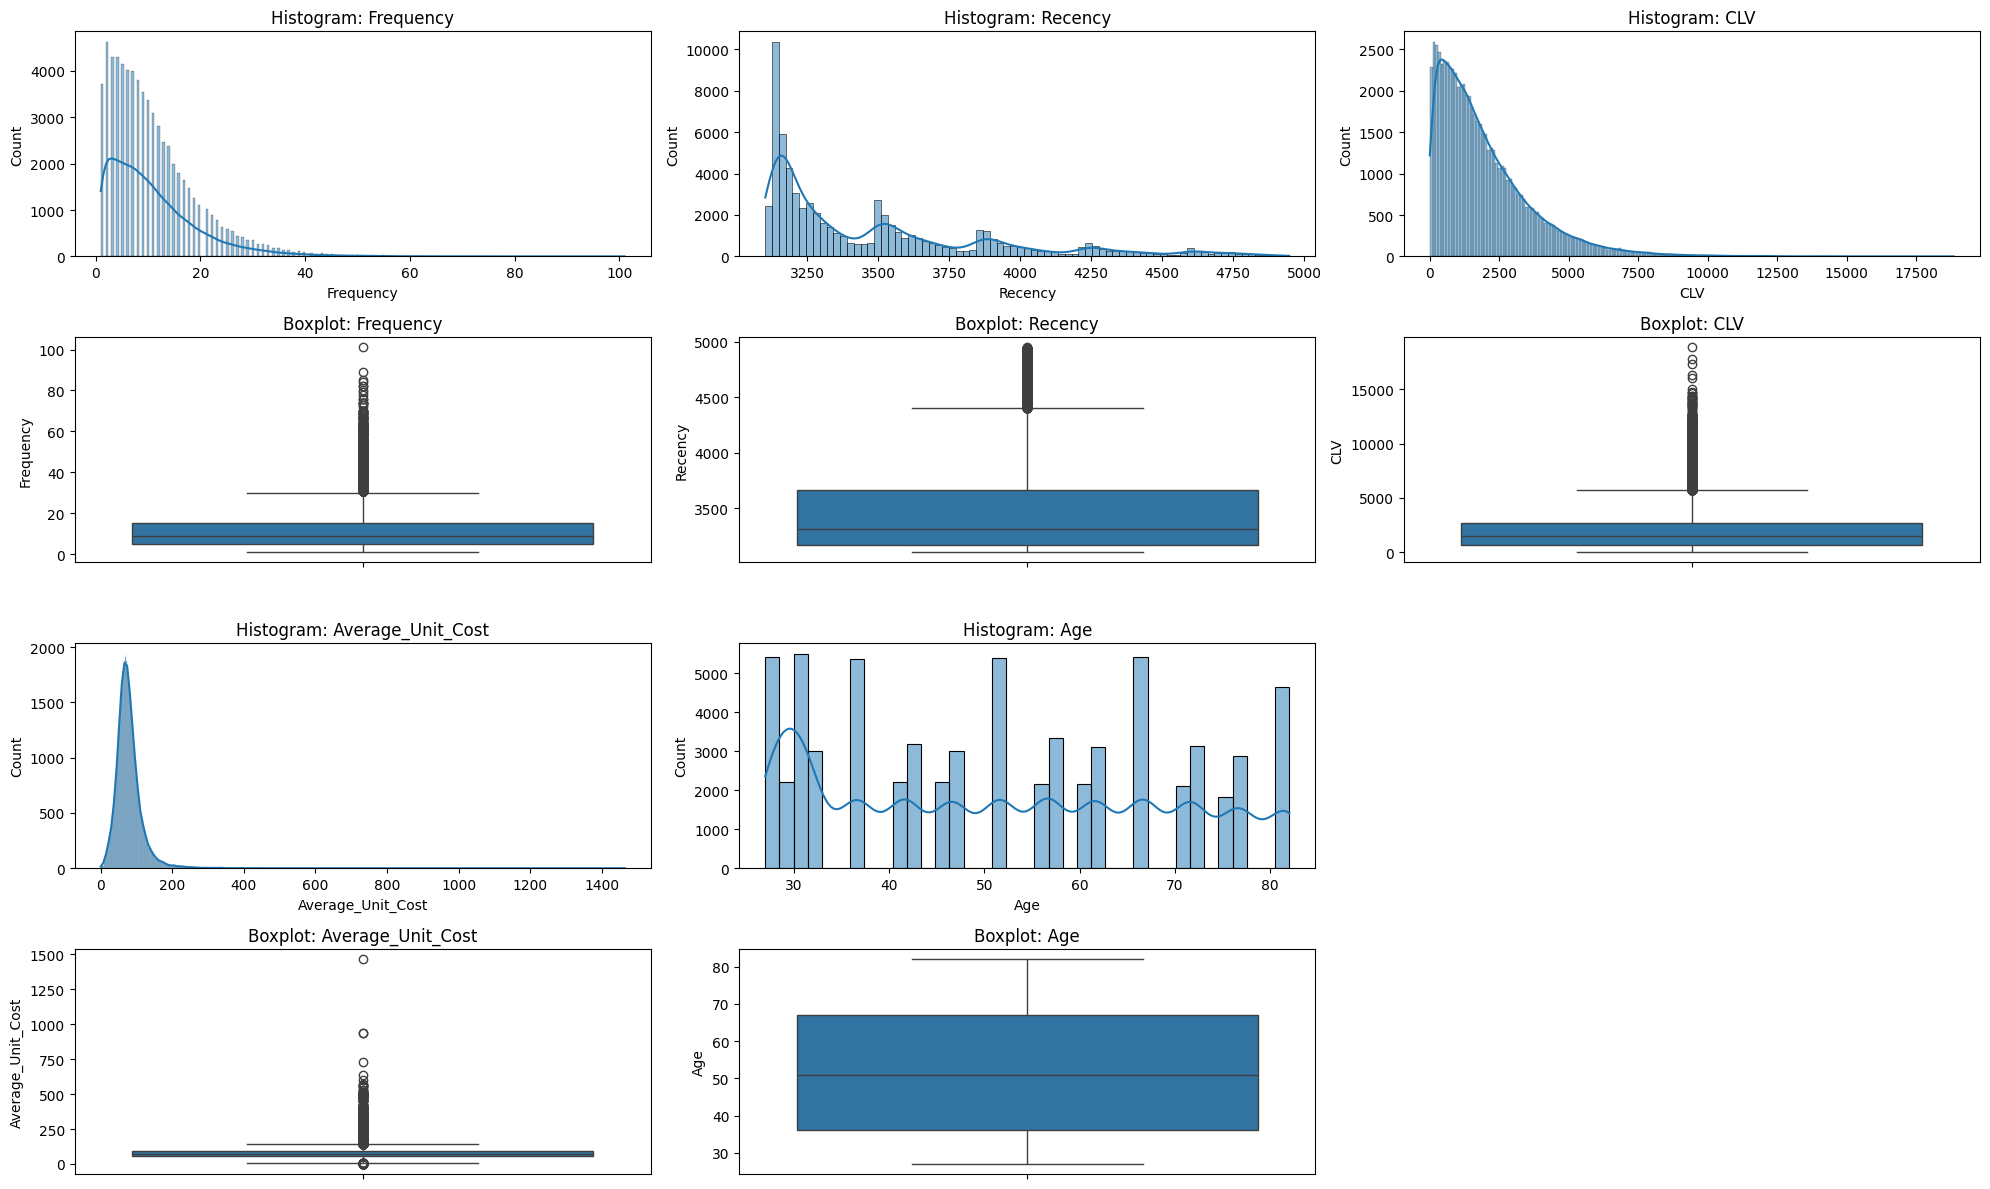

In [ ]:
#Visualize data distribution for each column with histogram and box plot
columns = df.columns
n_cols = len(columns)
n_rows = math.ceil(n_cols / 3)

#columns to plot
numeric_columns = df.select_dtypes(include=np.number).columns
n_numeric_cols = len(numeric_columns)

#plot settings
fig, axes = plt.subplots(n_rows * 2, 3, figsize=(20, n_rows * 6))


for idx, col in enumerate(numeric_columns):
    row = idx // 3
    col_pos = idx % 3

    # Histogram
    sns.histplot(df[col], kde=True, ax=axes[row * 2, col_pos])
    axes[row * 2, col_pos].set_title(f'Histogram: {col}')

    # Boxplot
    sns.boxplot(y=df[col], ax=axes[row * 2 + 1, col_pos])
    axes[row * 2 + 1, col_pos].set_title(f'Boxplot: {col}')

# Remove blank rows if present
for i in range(n_numeric_cols, n_rows * 3):
    fig.delaxes(axes[(i // 3) * 2, i % 3])
    fig.delaxes(axes[(i // 3) * 2 + 1, i % 3])

plt.tight_layout()
plt.show()

From EDA and descriptive analysis we identifies different high-value outliers for each column that need deeper understanding.

The differences between mean and median, with mean always higher than median, highlight right skewed distribution with different strength based on the feature



##Outliers (Isolation Forest)

In [13]:
#Isolation forest model with contamination = 0.05
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(df)

IsolationForest(contamination=0.05, random_state=42)

In [14]:
#predict the anomalies
y_pred = isolation_forest.predict(df)

In [15]:
#Import anomalies into the dataframe
df['anomalies'] = y_pred
df.head()

Customer ID  Frequency  Recency      CLV  Average_Unit_Cost  Age  anomalies
0           1         28     3141  4322.70          89.622857   71          1
1          10         23     3142  4611.29          80.996875   31          1
2        1000          7     3208  1381.70          71.300000   67          1
3       10001         37     3133  5742.37          73.054348   72         -1
4       10002         20     3221  4493.83          89.244828   31          1

In [16]:
#Scaling df to perform pca
df_scaled = df.drop('anomalies', axis=1)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns = df.drop('anomalies', axis=1).columns)

In [17]:
#Performing PCA to visualise the anomalies
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns = ['PC1', 'PC2'])
df_pca['anomalies'] = y_pred
df_pca.head()

PC1       PC2  anomalies
0  2.243595  0.488642          1
1  2.406714  0.472086          1
2 -0.375489  0.128134          1
3  3.358319 -0.031766         -1
4  2.087069  0.630672          1

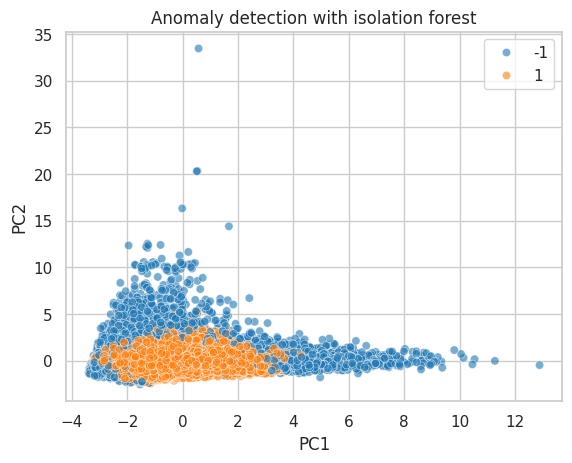

In [18]:
#Setting style
sns.set(style="whitegrid")

# Scatter plot for model

sns.scatterplot(x='PC1', y='PC2', hue = 'anomalies', data = df_pca, palette = 'tab10', alpha=0.6)

# Add labels and title using matplotlib functions
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Anomaly detection with isolation forest')
plt.legend()

# Show the plot
plt.show()

In [19]:
#anomalies count and percentage
total_anomalies = (df['anomalies'] == -1).sum()
total_observation = len(df)
anomaly_percentage = (total_anomalies / total_observation) * 100

#Summary table for anomalies

anomalies_table = pd.DataFrame({
    'Total Anomalies': [total_anomalies],
    'Total Observations': [total_observation],
    'Percentage of Anomalies': [anomaly_percentage]
})

anomalies_table

Total Anomalies  Total Observations  Percentage of Anomalies
0             3415               68300                      5.0

In [20]:
#Dataset cleaned from outliers
df_cleaned = df[df['anomalies'] == 1]
df_cleaned = df_cleaned.drop('anomalies', axis=1)
df_cleaned.head()

Customer ID  Frequency  Recency      CLV  Average_Unit_Cost  Age
0           1         28     3141  4322.70          89.622857   71
1          10         23     3142  4611.29          80.996875   31
2        1000          7     3208  1381.70          71.300000   67
4       10002         20     3221  4493.83          89.244828   31
5       10003          9     3215  2431.70          72.146667   67

After performing Isolation Forest with 5% contamination, the identified outliers were removed, creating df_cleaned as a new, clean DataFrame.

Outliers were also graphically visualized using PCA

#Clustering with ML models

In [21]:
#cleaned data set used
df_cleaned_copy = df_cleaned.copy()
df_cleaned = df_cleaned.drop(['Customer ID'], axis=1)
df_cleaned.head()

Frequency  Recency      CLV  Average_Unit_Cost  Age
0         28     3141  4322.70          89.622857   71
1         23     3142  4611.29          80.996875   31
2          7     3208  1381.70          71.300000   67
4         20     3221  4493.83          89.244828   31
5          9     3215  2431.70          72.146667   67

In [22]:
#Preprocessing data
#numerical features
numerical_features = df_cleaned.select_dtypes(include=np.number).columns

#Pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

#Fit and transform data
df_preprocessed = preprocessor.fit_transform(df_cleaned)

In [ ]:
#Segmentation with k-means (initialize to k=3)
kmeans = KMeans(n_clusters=3, random_state=42)

#Create a pipeline to preprocess and cluster dat
pipeline = Pipeline(steps = [('preprocessor', preprocessor), ('kmeans', kmeans)])

#Fit the pipeline
pipeline.fit(df_cleaned)

#Get the cluster assignements
cluster_labels = pipeline.predict(df_cleaned)


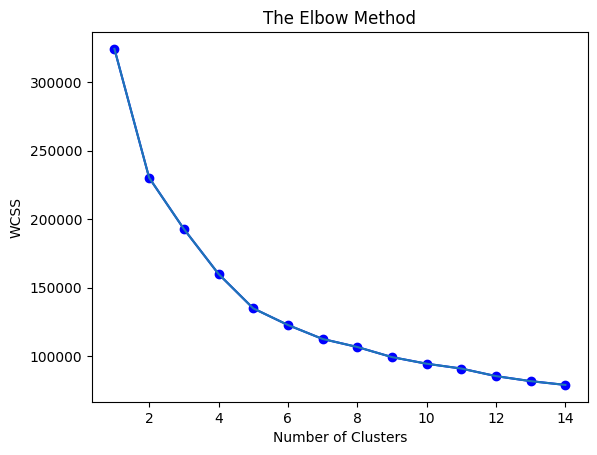

In [ ]:
# Elbow method: try different k.
wcss=[]
k_values = range(1, 15)

#Calculate WCSS in range 1 to 15
for i in range(1,15):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0, n_init = 'auto')
    kmeans.fit(df_preprocessed)
    wcss.append(kmeans.inertia_)

plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.plot(range(1,15),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
#Silhouette score
silhouette_scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i,  init='k-means++', random_state=0, n_init='auto')
    kmeans.fit(df_preprocessed)
    cluster_labels = kmeans.fit_predict(df_preprocessed)
    score = silhouette_score(df_preprocessed, cluster_labels)
    silhouette_scores.append(score)
    print(f"For k = {i}, the silhouette score is {score:.4f}")

For k = 2, the silhouette score is 0.2580
For k = 3, the silhouette score is 0.2309
For k = 4, the silhouette score is 0.2415
For k = 5, the silhouette score is 0.2536
For k = 6, the silhouette score is 0.2344
For k = 7, the silhouette score is 0.2220
For k = 8, the silhouette score is 0.2168
For k = 9, the silhouette score is 0.2186


Performing the elbow methods and the Shilouette score, we don't see a sharp difference in the elbow method, neither high values in Silhouette score. Even though, combining the two methods, we select k=4 as best cluster number due to his high silhouette score, and at the same time from the elbow plot, we observe lower variation in inertia increasing the number of clusters

To perform hierarcal clustering, we reduce the sample to 25000 observations

In [ ]:
df_preprocessed = pd.DataFrame(df_preprocessed)
smaller_preprocessed = df_preprocessed.sample(n=25000, random_state=42).reset_index(drop=True)

In [ ]:
# Function to create a dendrogram using a given linkage metric
def plot_dendrogram(X, method, ax):
    linked = linkage(X, method=method)
    dendrogram(linked, ax=ax,truncate_mode='lastp', p=10)
    ax.set_title(f'Dendrogram ({method.capitalize()} Linkage)')

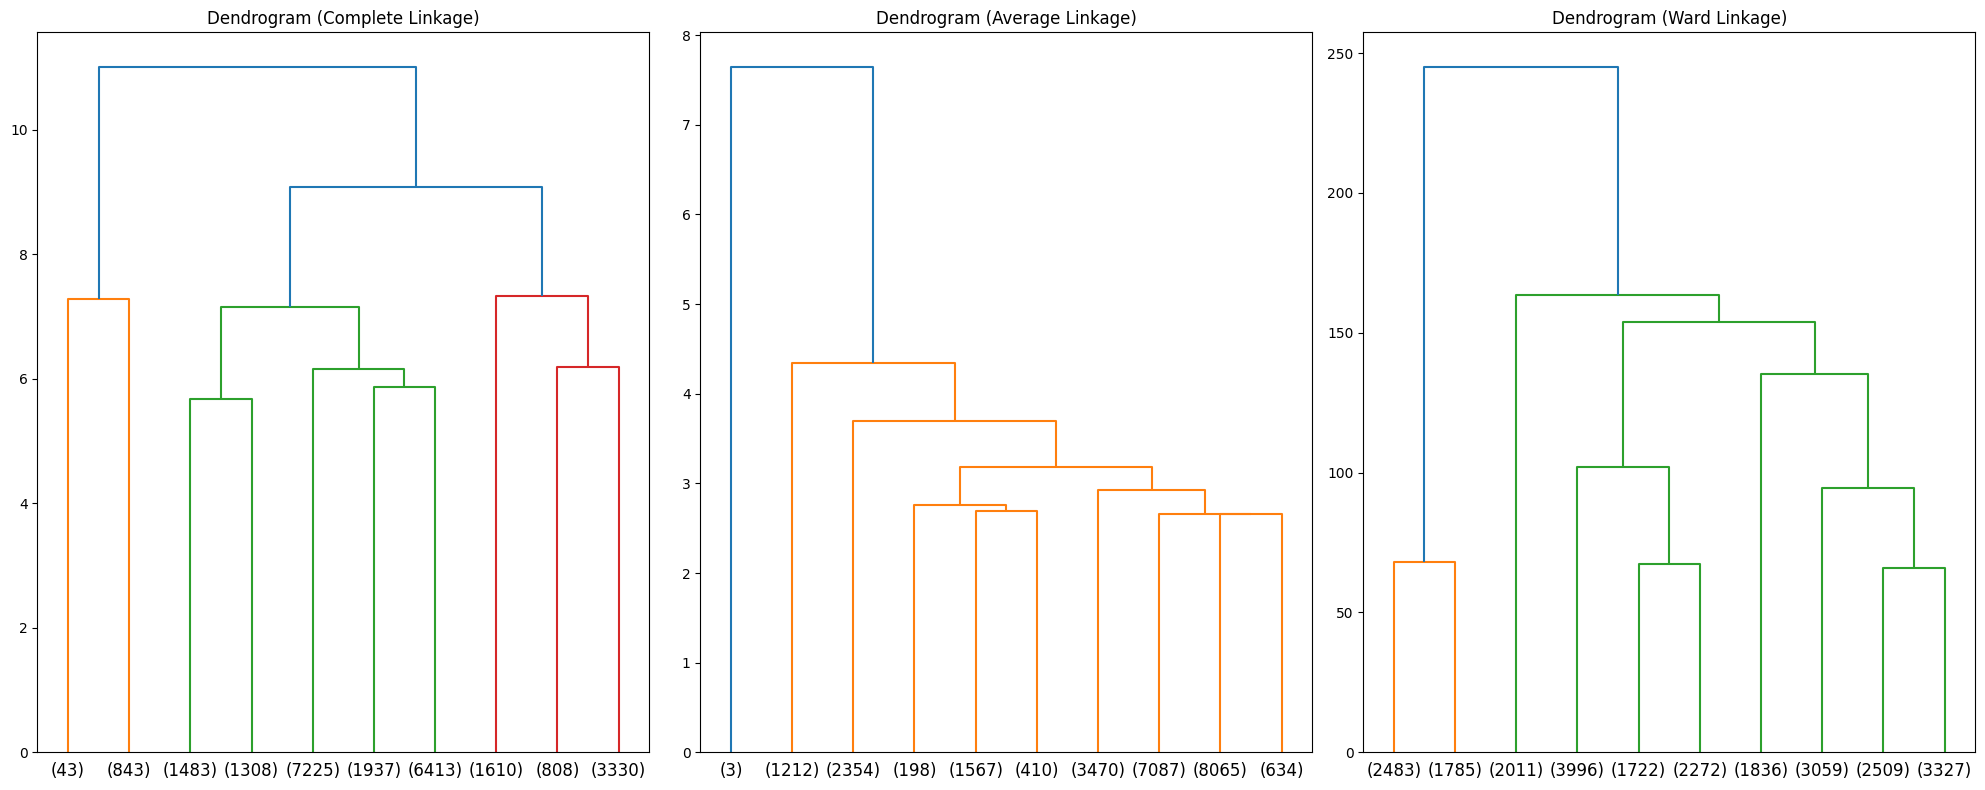

In [ ]:
# Define the linkage methods
linkage_methods = ['complete', 'average', 'ward']

fig, axes = plt.subplots(1,3, figsize=(20, 8))

# Plot dendrograms for each linkage method
for i, method in enumerate(linkage_methods):
    plot_dendrogram(smaller_preprocessed, method, axes[i])

# Display the plots
plt.tight_layout()
plt.show()

After interpreting the hierarchical dendrograms with different linkage methods and comparing them with the silhouette score and elbow method, k=4 appears to be the optimal compromise and represents the most robust number of clusters.

From the dendrograms, there is not a clear distinction, with different linkage suggesting different number of clusters (compleate: k=3/6, average: k=2/3, ward: k=4). Comparing also Elbow method and Silhouette score, we select k=4 as best compromise between the methods, with a Silhouette score of 0.2415, a decrease in inertia from Elbow plot and the visualisation of dendrogram with ward linkage.

#Customer segments

In [23]:
#labelling observation with clusters
#Segmentation with k-means
kmeans = KMeans(n_clusters=4, random_state=42)
pipeline = Pipeline(steps = [('preprocessor', preprocessor), ('kmeans', kmeans)])
pipeline.fit(df_cleaned)
cluster_labels = pipeline.predict(df_cleaned)
df_cleaned['Cluster'] = cluster_labels
df_cleaned['Customer ID'] = df_cleaned_copy['Customer ID']

df_cleaned.head()

Frequency  Recency      CLV  Average_Unit_Cost  Age  Cluster Customer ID
0         28     3141  4322.70          89.622857   71        3           1
1         23     3142  4611.29          80.996875   31        3          10
2          7     3208  1381.70          71.300000   67        1        1000
4         20     3221  4493.83          89.244828   31        3       10002
5          9     3215  2431.70          72.146667   67        1       10003

In [24]:
#Dataframe for Customer ID and Cluster
customer_cluster = df_cleaned[['Customer ID', 'Cluster']]
customer_cluster

Customer ID  Cluster
0               1        3
1              10        3
2            1000        1
4           10002        3
5           10003        1
...           ...      ...
68295        9994        0
68296        9995        2
68297        9996        3
68298        9997        2
68299        9999        1

[64885 rows x 2 columns]

In [ ]:
#Client in each segment
descriptive_Stat = round(df_cleaned.groupby('Cluster').describe().T,2)
descriptive_Stat

Cluster                         0         1         2         3
Frequency         count  15801.00  11274.00  26604.00  11206.00
                  mean      20.85      4.39      8.44      6.94
                  std        5.99      3.16      4.07      3.47
                  min        7.00      1.00      1.00      1.00
                  25%       16.00      2.00      5.00      4.00
                  50%       20.00      4.00      8.00      7.00
                  75%       24.00      6.00     11.00     10.00
                  max       48.00     26.00     21.00     18.00
Recency           count  15801.00  11274.00  26604.00  11206.00
                  mean    3255.85   4148.87   3318.85   3472.10
                  std      181.47    309.47    180.36    298.68
                  min     3103.00   3560.00   3110.00   3111.00
                  25%     3141.00   3894.00   3163.00   3207.00
                  50%     3176.00   4087.00   3255.00   3415.00
                  75%     3287.00   4360.00   3491.00   3654.00
                  max     4282.00   4947.00   3954.00   4721.00
CLV               count  15801.00  11274.00  26604.00  11206.00
                  mean    3806.64    643.07   1185.93   1773.30
                  std     1145.75    564.01    668.27    936.30
                  min     1624.40      0.63      2.00     95.90
                  25%     2919.58    210.22    643.50   1048.18
                  50%     3580.80    478.55   1149.94   1701.70
                  75%     4499.30    927.02   1691.50   2405.40
                  max     8666.50   4464.60   3501.90   5810.40
Average_Unit_Cost count  15801.00  11274.00  26604.00  11206.00
                  mean      79.66     62.18     61.78    119.67
                  std       16.73     24.91     16.76     25.77
                  min       32.85      0.50      1.20     77.58
                  25%       67.63     43.88     50.50    100.34
                  50%       77.96     61.16     62.65    112.96
                  75%       89.87     79.10     74.43    132.06
                  max      155.38    155.70     99.00    295.90
Age               count  15801.00  11274.00  26604.00  11206.00
                  mean      46.78     56.41     52.67     50.78
                  std       15.07     18.23     17.60     17.32
                  min       27.00     27.00     27.00     27.00
                  25%       32.00     41.00     36.00     36.00
                  50%       46.00     57.00     52.00     51.00
                  75%       57.00     72.00     67.00     66.00
                  max       82.00     82.00     82.00     82.00

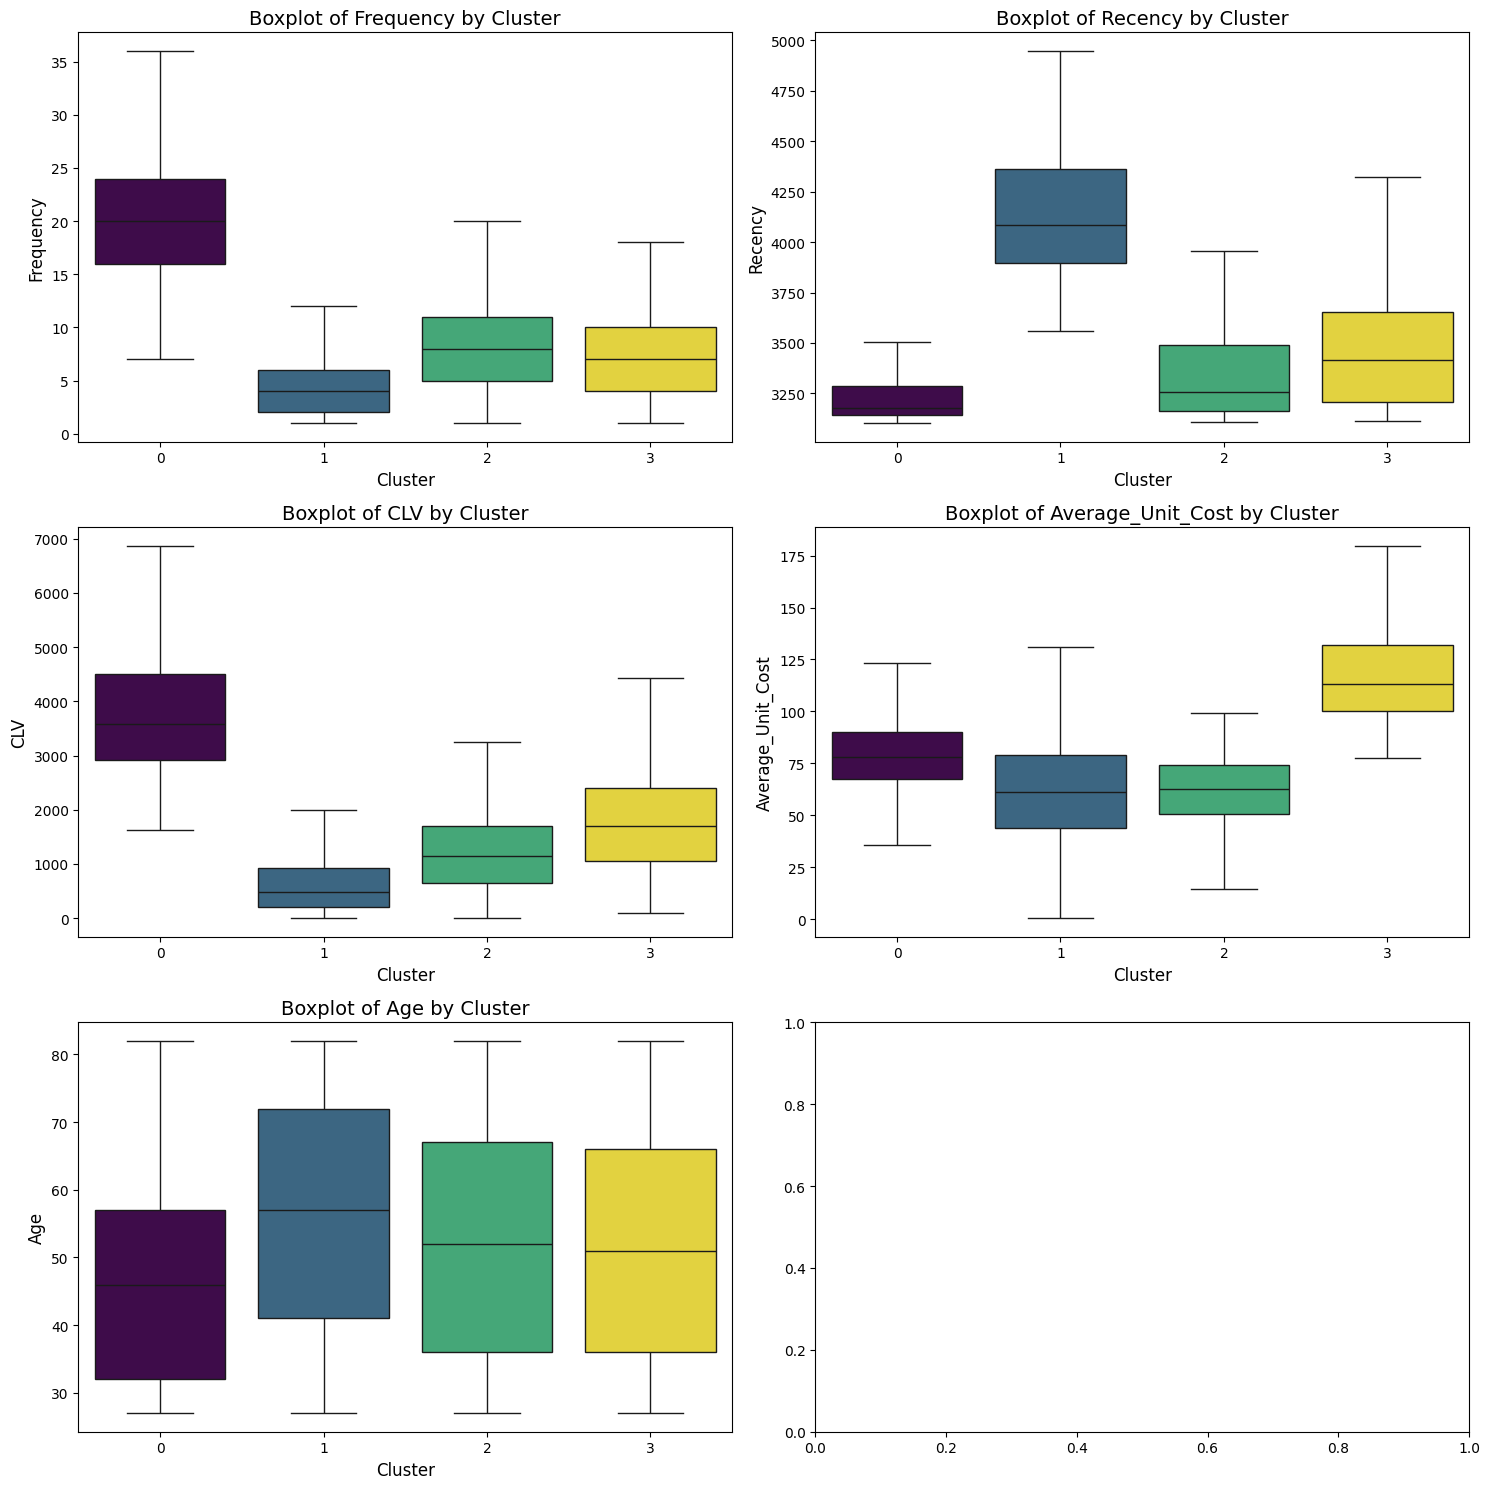

In [ ]:
#Plotting market segmentation
numerical_features_plot = df_cleaned.select_dtypes(include=np.number).columns

#Determine the number of plots and layout for subplots
n_features_plot = len(numerical_features_plot)
n_col = 2
n_rows_plot = (n_features_plot+n_col-1)//n_col

fig, axes = plt.subplots(n_rows_plot, n_col, figsize=(15, 5*n_rows_plot))

axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    ax = axes[idx]
    sns.boxplot(x='Cluster', y=col, data=df_cleaned, ax=ax, hue='Cluster', palette='viridis', legend=False, showfliers=False)

    ax.set_title(f'Boxplot of {col} by Cluster', fontsize = 14)
    ax.set_xlabel('Cluster', fontsize = 12)
    ax.set_ylabel(col, fontsize = 12)

for i in range (n_features_plot, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

After identiftying 4 as best number of clusters, it is added to *df_cleaned*, retriving the association between each customer and his cluster.

It was then performed an analysis to identify the difference between clusters, through descriptive statistics and boxplots

#Dimensionality reduction

##PCA (Pricipal Component Analysis)

In [25]:
#Reset index for df_cleaned
df_cleaned = df_cleaned.drop('Customer ID', axis=1)
df_cleaned = df_cleaned.reset_index(drop=True)

In [26]:
#scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cleaned.drop(['Cluster'], axis=1))
scaled_df = pd.DataFrame(scaled_data, columns = df_cleaned.drop(['Cluster'], axis=1).columns)
scaled_df.head()

Frequency   Recency       CLV  Average_Unit_Cost       Age
0   2.340780 -0.851567  1.728556           0.459131  1.118599
1   1.671966 -0.849018  1.928799           0.164019 -1.182796
2  -0.468241 -0.680829 -0.312105          -0.167731  0.888459
3   1.270677 -0.647701  1.847298           0.446198 -1.182796
4  -0.200716 -0.662991  0.416455          -0.138765  0.888459

In [27]:
#Performing PCA and creating new dataset with PCA and clusters
pca = PCA(n_components=2)
df_pca = pca.fit_transform(scaled_df)
df_pca = pd.DataFrame(df_pca, columns = ['PC1', 'PC2'])
df_pca

PC1       PC2
0      2.724823 -0.357544
1      2.818529 -0.122673
2     -0.380520 -0.364060
3      2.491358  0.275390
4      0.230544 -0.338668
...         ...       ...
64880 -2.656815  0.405857
64881 -0.097883  0.269240
64882  2.210458  0.610587
64883 -0.039233  1.053232
64884  0.544980 -1.133775

[64885 rows x 2 columns]

In [28]:
#Dataset for PCA visualisation
df_pca['Cluster'] = df_cleaned['Cluster']
df_pca

PC1       PC2  Cluster
0      2.724823 -0.357544        3
1      2.818529 -0.122673        3
2     -0.380520 -0.364060        1
3      2.491358  0.275390        3
4      0.230544 -0.338668        1
...         ...       ...      ...
64880 -2.656815  0.405857        0
64881 -0.097883  0.269240        2
64882  2.210458  0.610587        3
64883 -0.039233  1.053232        2
64884  0.544980 -1.133775        1

[64885 rows x 3 columns]

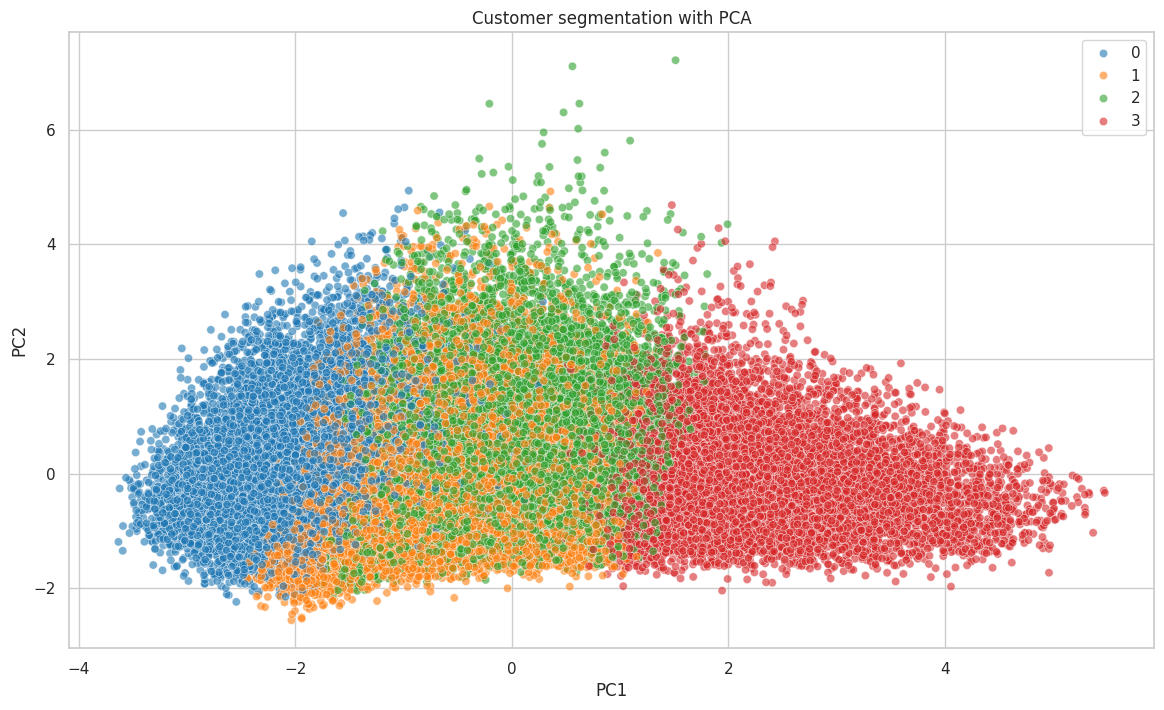

In [29]:
#Plotting clusters with PCA
#Setting style
sns.set(style="whitegrid")

#Setting plot dimension
plt.figure(figsize=(14, 8))

#Scatter plot
sns.scatterplot(x='PC1', y='PC2', hue = 'Cluster', data = df_pca, palette = 'tab10', alpha=0.6)

# Add labels and title using matplotlib functions
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer segmentation with PCA')
plt.legend()

# Show the plot
plt.show()

Data reduction and visualization with PCA doesn't show great distinction among clusters; in particular, clusters 0 and 1 are very similar (as seen in the boxplots).

##t-SNE

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64885 entries, 0 to 64884
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Frequency          64885 non-null  int64  
 1   Recency            64885 non-null  int64  
 2   CLV                64885 non-null  float64
 3   Average_Unit_Cost  64885 non-null  float64
 4   Age                64885 non-null  int64  
 5   Cluster            64885 non-null  int32  
dtypes: float64(2), int32(1), int64(3)
memory usage: 2.7 MB


In [33]:
#Definition of t-SNE plot
def plot_tsne(X, title, y_subset):
  '''
  Function to plot t-SNE.
  X = data
  title = title of the plot
  y_subset = subset of the data to plot
  '''
  plt.figure(figsize=(10, 10))
  for i in range(4):
      plt.scatter(X[y_subset == i, 0], X[y_subset == i, 1], label=str(i))
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.legend()
  plt.title(title)
  plt.grid(True)
  plt.show()

In [31]:
#Dataset for t-SNE visualisation
scaled_df_tsne = scaled_df
scaled_df_tsne['Cluster'] = df_cleaned['Cluster']
scaled_df_tsne

Frequency   Recency       CLV  Average_Unit_Cost       Age  Cluster
0       2.340780 -0.851567  1.728556           0.459131  1.118599        3
1       1.671966 -0.849018  1.928799           0.164019 -1.182796        3
2      -0.468241 -0.680829 -0.312105          -0.167731  0.888459        1
3       1.270677 -0.647701  1.847298           0.446198 -1.182796        3
4      -0.200716 -0.662991  0.416455          -0.138765  0.888459        1
...          ...       ...       ...                ...       ...      ...
64880  -1.137056  2.308352 -1.122402          -0.136940  1.406273        0
64881  -0.468241 -0.624766 -0.246604           0.350771 -0.032098        2
64882   1.270677 -0.673184  1.492850           0.989063 -0.262238        3
64883  -0.200716  0.527075 -0.100684           0.761592 -1.240330        2
64884   0.869388 -0.691022 -0.050031          -0.724083  0.600785        1

[64885 rows x 6 columns]

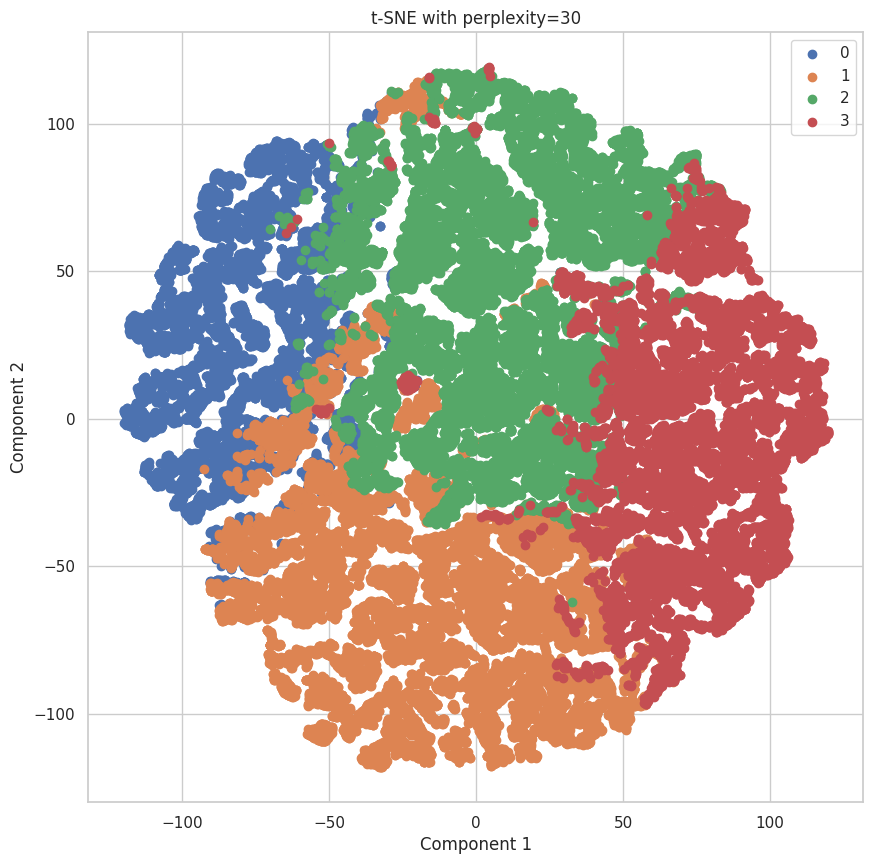

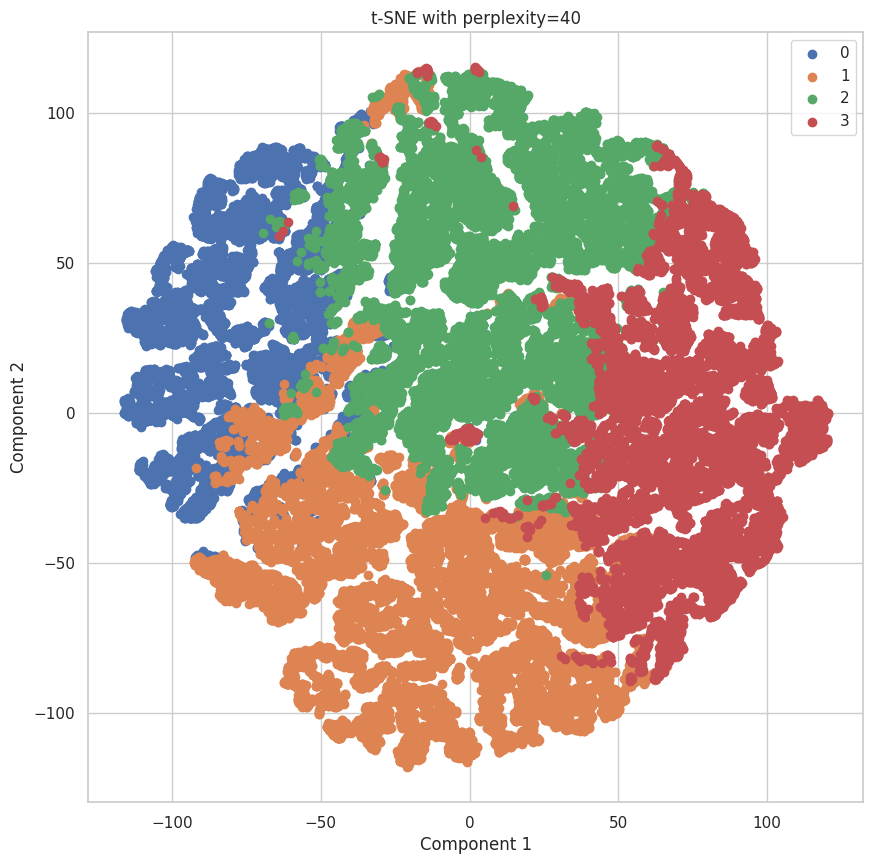

In [34]:
#t-SNE model scaled
for index, p in enumerate([30,40]):
  tsne_scaled = TSNE(n_components=2, perplexity=p, random_state=42)
  X_tsne_scaled = tsne_scaled.fit_transform(scaled_df_tsne.drop(['Cluster'], axis = 1))
  plot_tsne(X_tsne_scaled, f't-SNE with perplexity={p}', scaled_df_tsne['Cluster'])

Data reduction and visualisation with t-SNE and perplexity equals to 40 highlights the distance between the data

##Data reduction comparison

In [35]:
def plot_tsne_sub(X, title, y_subset, ax, palette='tab10'):
    '''
    Function to plot t-SNE on a specific matplotlib Axes object.
    X = data (t-SNE components, e.g., X_tsne_scaled)
    title = title of the plot
    y_subset = cluster labels for coloring
    ax = the matplotlib Axes object to plot on
    palette = optional color palette for Seaborn
    '''

    f_tsne_df = pd.DataFrame(X, columns=['t-SNE1', 't-SNE2'])
    f_tsne_df['Cluster'] = y_subset

    sns.scatterplot(
        x='t-SNE1',
        y='t-SNE2',
        hue='Cluster',
        data=f_tsne_df,
        palette=palette,
        ax=ax,
        alpha=0.7,
        s=50
    )


    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(title)
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

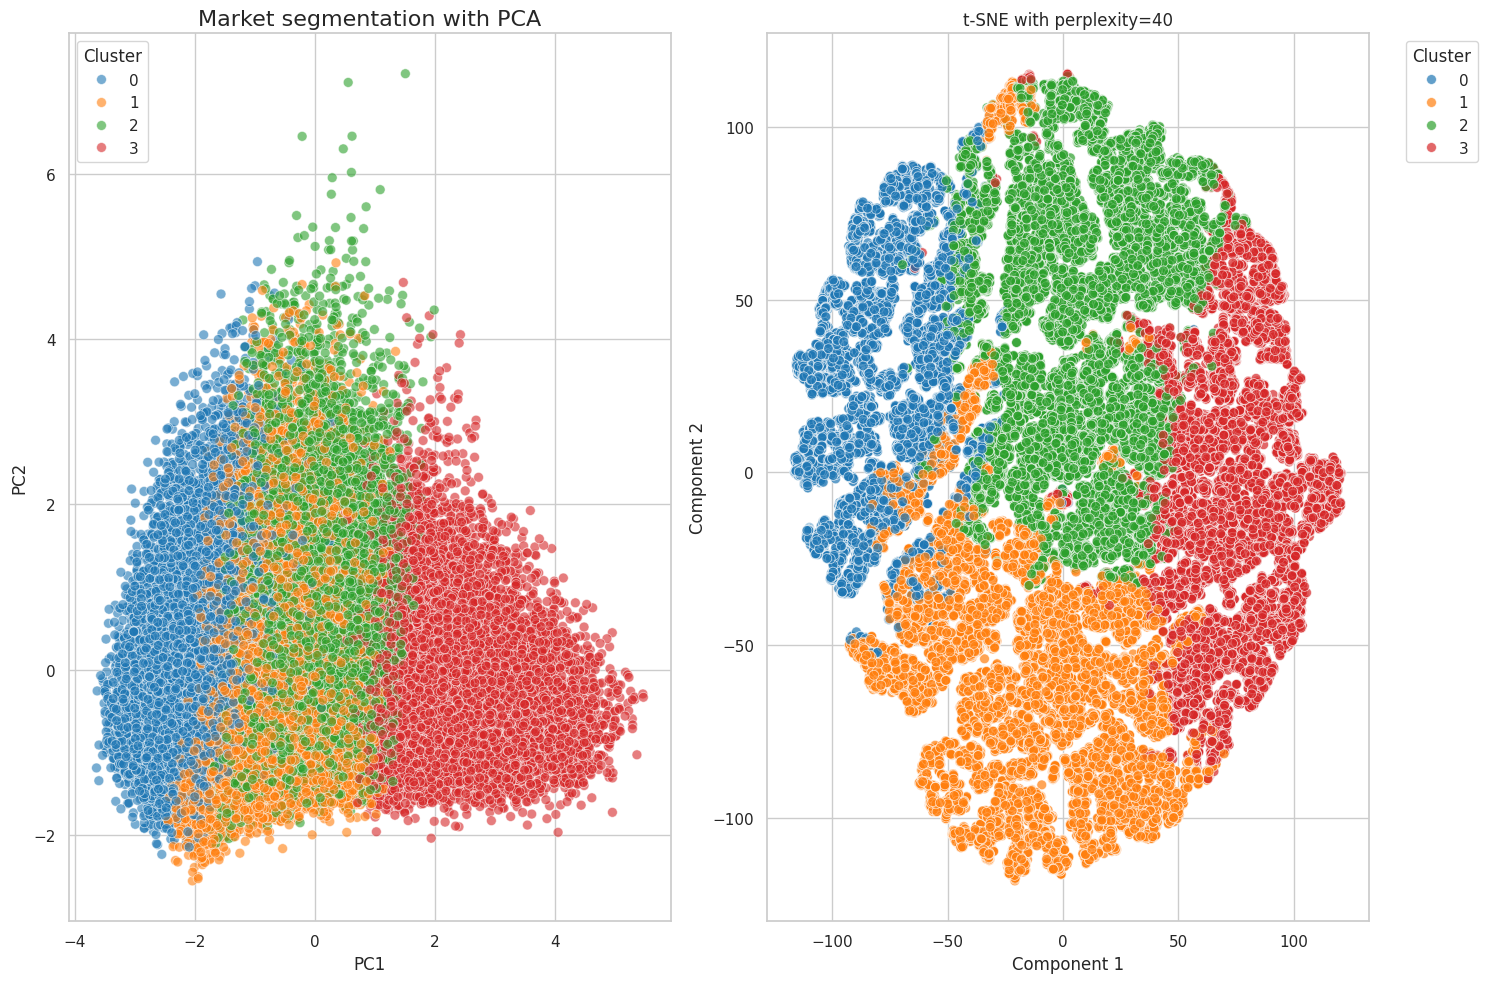

In [36]:
#Visualisation comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

#PCA visualisation
sns.scatterplot(x='PC1', y='PC2', hue = 'Cluster', data = df_pca, ax = axes [0], palette='tab10', alpha=0.6, s=50)

# Add labels and title using matplotlib functions
axes[0].set_title('Market segmentation with PCA', fontsize=16)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].legend(title='Cluster',  loc='upper left')

#t-SNE visualisation
tsne_scaled = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne_scaled = tsne_scaled.fit_transform(scaled_df_tsne.drop(['Cluster'], axis = 1))
plot_tsne_sub(X=X_tsne_scaled, title=f't-SNE with perplexity=40',y_subset=scaled_df_tsne['Cluster'], ax=axes[1])

plt.tight_layout()
plt.show()

Comparing the two different techniques, with t-SNE we can better appreciate the distinction and distance among clusters. With PCA, clusters appear similar and sometimes overlapping, but this is due to the dimensionality reduction.

### Reference:
SAS, 2024. CUSTOMERS_CLEAN [Data set]. SAS. Last revised on 15 December 2021. [Accessed 20 February 2024].